# **AM 207**: Homework 3

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 24th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW3.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW3.tar.gz or AM207_YOURNAME_HW3.zip


### Have Fun!
_ _ _ _ _

In [971]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Employee Satisfaction Improvement
This problem is going to explore the differences between complete pooling, unpooling and partial pooling for a normal model with observed standard deviations. 

You are working for a consulting firm which is trying to find a good strategy to improve employee satisfaction for their customers. Your company ran pilot studies in eight different customer companies and measured the improvement in employee satisfaction after the plan had been implemented for two years. The data you are given is the mean and standard deviation of the satisfaction improvement, measured by a survey. 
You follow the nature of your data by modeling the effect of the strategie with a normal model. To simplify things you can assume that the different standard deviations are an effect of different sample sizes, and that there is actually one underlying observation variance:

$$ \sigma_j^2 = \frac{\sigma^2}{n_j}$$

Thus the difference in the observed standard deviations in the survey results are caused by having different numbers of survey answers $n_j$. 

Discuss, create and compare three different solutions for your model using PYMC or another sampling method of your choice:

* complete pooling
* unpooling
* partial pooling

In [1711]:
# Here is the data
data = np.double(np.array([[29.5,18.4],[6.3,12.7],[-3.9,15.9],[7.2,10.2],[-2.1,9.0],[1.8,12.1],[19.6,7.3],[12,18.6]]))
data_means = data[:,0]
data_std = data[:,1]

In [1714]:
# This problem and the data are nearly identical to the one explained in Gelman Chapter 5 for SAT score improvement

print data_means
print data_std

[ 29.5   6.3  -3.9   7.2  -2.1   1.8  19.6  12. ]
[ 18.4  12.7  15.9  10.2   9.   12.1   7.3  18.6]


## Complete Pooling

Estimate of the common mean in the pooled case is given in Gelman (5.13)


In [1810]:
mean_pooled=np.sum([(1/(data_std[i])**2)*data_means[i] for i in xrange(len(data))])/  \
            np.sum([1/(data_std[i]**2) for i in xrange(len(data))])
print "Mean from complete pooling:", mean_pooled

Mean from complete pooling: 8.95046875093


The formula for the common standard deviation is given in Gelman on page 144:

In [1811]:
std_pooled = np.sqrt(np.sum([1/data_std[i]**2 for i in range(len(data))])**-1)
print "Standard Deviation from complete pooling:", std_pooled

Standard Deviation from complete pooling: 3.96673968131


## Partial Pooling

In [1872]:
# I set uniform prior on the mean, with a wide uninformative prior
mu_prior = pm.Uniform("mu_prior", 0,25)

sample_means = pm.Container([pm.Normal("mean_%i" % i, mu=mu_prior, tau=data_std[i], trace=False) for\
                                                                                             i in range(8)])
@pm.observed
def likelihood(value=data, means=sample_means):
    likelihoodd = 0
    for i in range(len(data)):
        likelihoodd += pm.normal_like(value[i][0], mu=means[i], tau=value[i][1]) 
    return likelihoodd

M = pm.MCMC([data, mu_prior, sample_means, likelihood])
M.sample(11000,1000,10)

 [-----------------100%-----------------] 11000 of 11000 complete in 4.5 sec

In [1873]:
M.stats()

{'mu_prior': {'95% HPD interval': array([ 9.37611385,  9.90265368]),
  'mc error': 0.0096116044520818556,
  'mean': 9.643897283085261,
  'n': 1000,
  'quantiles': {2.5: 9.3800544468403135,
   25: 9.550534724290312,
   50: 9.6399254051514145,
   75: 9.742039677531757,
   97.5: 9.9138220635061156},
  'standard deviation': 0.13929719306529859}}

Plotting mu_prior


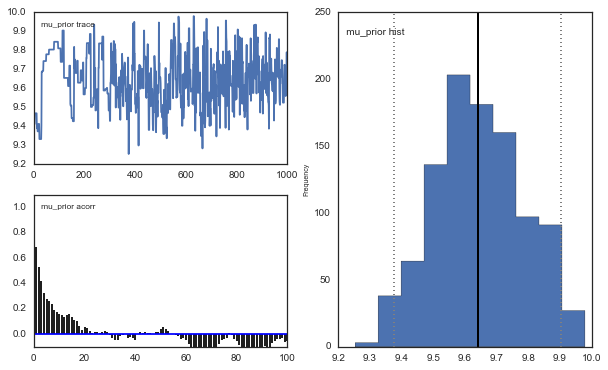

In [1874]:
pm.Matplot.plot(mu_prior)

### So my partial pooling estimate for the mean is 9.64, with an error of 0.14.

## Unpooling

In [1902]:
# This time, each mean has its own prior
mu_priors = pm.Container([pm.Uniform("mu_priors_%i" %i, -5,35) for i in range(8)])

sample_means = pm.Container([pm.Normal("mean_%i" % i, mu=mu_priors[i], tau=data_std[i], trace=False) for\
                                                                                             i in range(8)])

@pm.observed
def likelihood(value=data, means=sample_means):
    likelihoodd = 0
    for i in range(len(data)):
        likelihoodd += pm.normal_like(value[i][0], mu=means[i], tau=value[i][1]) 
    return likelihoodd

M = pm.MCMC([data, mu_priors, sample_means, likelihood])
M.sample(10000,100)

 [-----------------100%-----------------] 10000 of 10000 complete in 6.3 sec

In [1903]:
# This time, the means are all produced from their own priors, so there are 8 means to report:

In [1904]:
M.stats()

{'mu_priors_0': {'95% HPD interval': array([ 28.85609024,  30.13776965]),
  'mc error': 0.014249648318217175,
  'mean': 29.522874010890256,
  'n': 9900,
  'quantiles': {2.5: 28.857444745208458,
   25: 29.297969132457204,
   50: 29.52816632521769,
   75: 29.740974771500003,
   97.5: 30.149355588341656},
  'standard deviation': 0.32863700634715148},
 'mu_priors_1': {'95% HPD interval': array([ 5.68502928,  7.17624433]),
  'mc error': 0.029663344024752049,
  'mean': 6.3589690110832704,
  'n': 9900,
  'quantiles': {2.5: 5.6392954778930191,
   25: 6.0744715572671009,
   50: 6.3427831078396171,
   75: 6.6233365405835629,
   97.5: 7.1500282878707742},
  'standard deviation': 0.44086548913926632},
 'mu_priors_2': {'95% HPD interval': array([-4.56823127, -3.17003875]),
  'mc error': 0.0260792979651732,
  'mean': -3.8936254545517928,
  'n': 9900,
  'quantiles': {2.5: -4.5792578620279167,
   25: -4.177721965982129,
   50: -3.9126117304887997,
   75: -3.6549047030218489,
   97.5: -3.17003875229355

For each mu, we can compare its observation with its predicted value and error:

In [1906]:
for i in range(8):
    print "Observed:", data_means[i]
    print "Unpooling estimate:", "{0:.2f}".format(M.stats()['mu_priors_%i' % i]['mean'])
    print "Error of estimate:", "{0:.2f}".format(M.stats()['mu_priors_%i' %i]['standard deviation'])
    print
    

Observed: 29.5
Unpooling estimate: 29.52
Error of estimate: 0.33

Observed: 6.3
Unpooling estimate: 6.36
Error of estimate: 0.44

Observed: -3.9
Unpooling estimate: -3.89
Error of estimate: 0.37

Observed: 7.2
Unpooling estimate: 7.23
Error of estimate: 0.43

Observed: -2.1
Unpooling estimate: -2.09
Error of estimate: 0.46

Observed: 1.8
Unpooling estimate: 1.75
Error of estimate: 0.39

Observed: 19.6
Unpooling estimate: 19.58
Error of estimate: 0.54

Observed: 12.0
Unpooling estimate: 12.02
Error of estimate: 0.38



# Problem 2: Motif Finding Using Gibbs

One interesting problem in bioinformatics is that of finding common subsequences of nucleotid bases (these subsequences are called motifs) that repeat themselves within larger DNA sequences. The problem is relevant for genetics because locating the positions of these motifs within the DNA sequence helps in the understanding of how genes are regulated.

Suppose that you are a biologist who is analyzing genetic material collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases. Let us label these extraterrestrial nucleotides and put them in a vector $\mathbf{b} = [\rm{M}, \rm{0}, \rm{2}, \rm{A}, \rm{7}]$. You have a DNA sample $\mathcal{S}$ consisting of $p=20$ sequences of DNA, each of them with a lenght $l=200$ nucleotide bases that you can find in <a href="HW3/Sequences_new.dat">this file</a>. Each row of the file is a DNA sequence. You are asked to find a motif of $q = 5$ consecutive nucleotides hidden in the background that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences.

Let us formalize the problem. The starting positions of the motif within each sequence (our missing data in the problem) can be represented by the set of random variables:

$$
\mathcal{A} = \left\{a_k, k = 1,...,p\right\}
$$

The motif has to start somewhere within the sequences and so for each sequence $\mathcal{S_k}$:

$$
\sum_{i=1}^{l}P(a_k=i) = 1
$$

What we are after is the joint distribution $P(\mathcal{A}|\mathcal{S})$ for the motif alignment (i.e., its starting position) being $a_k$ for sequence $\mathcal{S}_k$. As shown in [this paper](http://www.cs.cmu.edu/~epxing/Class/10810/readings/liu.pdf), for each sequence $\mathcal{S}_k$ (think of each sequence as a dimension of our parameter space) we can obtain the conditional probability: 

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

where $\mathcal{A_{\hat{k}}}$ refers to the alignments in all sequences other than $\mathcal{S}_k$, and $Z$ is a normalization factor. Of the other quantities, $s_x$ is a vector index for the *x-th* position in the sequence, with the same length as $\mathbf{\hat{\theta_j}}$ and $\mathbf{b}$. It takes a value of 1 at the entry that in $\mathbf{b}$ corresponds to the base at position $x$ and 0 for all other entries. Finally, vectors $\mathbf{\hat{\theta_j}}$ and $\mathbf{\hat{\theta_0}}$ contain respectively the probabilities of observing the $q$ bases at the corresponding position of the current sequence, and the probabilities of finding the same bases in the background. It is important to note that the power, division, and multiplication of vectors in the equation above is performed entry-wise.

Your only task is to design a Gibbs algorithm that samples the joint probability $P(\mathcal{A}|\mathcal{S})$. Your algorithm should converge and provide the alignments of the motif and the secret motif itself. Here are some hints/tasks that should help you and that will help the TF grading your homework:

(a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

(b) Start by assigning random starting positions for the $q$-long motif in all sequences. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

(c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

(d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.


## Solution:
(a) The equation for the conditional probabilities states that the probability that the starting position of the motif in a given sequence is equal to a starting position i, given the other sequences, is equal to a normalized product of five terms.  The exponent is equal to 1 or 0 to select the appropriate position within the motif.  Each term of the product is the quotient of the probability of observing the base at that position within the current sequence and the probability of observing the base at that position in the other 19 sequences.  

In [972]:
# Load the data
data = np.loadtxt('../Homeworks/HW3/Sequences_new.dat',dtype=str)

(b) Assign random starting positions for the motif.  

In [881]:
starting_positions = np.random.randint(0,194,20)
starting_positions

array([140,  99,  72,  12, 182,  91,  43,  72,  37, 143,  60,  17,  53,
       171,  33,  89, 187,  53,  32,  19])

In [882]:
# The motif for the kth sequence with the given random starting position. 
# To demonstrate, I display the motif for the 0th sequence.  
k=0
motif = data[k][starting_positions[k]:starting_positions[k]+5]
print motif

0A07M


To create the matrix for the kth sequence, I will have to count how many times the ith value from the motif occurs in the jth position for each of the other 19 sequences

In [883]:

# I create a list of indexes for the 20 sequences.  I remove the index of the current sequence
seq_starting_idxs = range(20); seq_starting_idxs.remove(k)

# I create list of empty strings that I will add all of the bases for given positions to
base_counts = ['','','','','']

# I also create a string for the background
background = ''

# Now for each of the 19 sequences, I add the base at the corresponding position within the motif for each of the 
#    five positions within the motif.
for seq in seq_starting_idxs:
    # Add the nucleotide base that occurs at each motif position in this sequence.
    base_counts[0] += data[seq][starting_positions[seq]+0]
    base_counts[1] += data[seq][starting_positions[seq]+1]
    base_counts[2] += data[seq][starting_positions[seq]+2]
    base_counts[3] += data[seq][starting_positions[seq]+3]
    base_counts[4] += data[seq][starting_positions[seq]+4]
    
    # Add the background bases.
    background += data[seq][0:starting_positions[seq]] + data[seq][starting_positions[seq]+5:len(data[seq])]
print base_counts

['MM022MA7A7720M22700', '72007A2MA20A7A0A70A', '700M00A2A7AMMMA0770', '7AM0MA2AMAAMA07M220', 'A27AMAAM2270M00077A']


In [884]:
# From these, I can generate my matrix:
theta_j = np.zeros((5,5))
theta_0 = np.zeros(5)
for motif_position in range(5):
    # For each possible base, count how many of this base was present in each motif position.
    # Each row of the matrix corresponds to the nucleotides A, M, 2, 0, and 7.  
    # Each column corresponds to the jth positions within the motifs.  
    for idx, base in enumerate('AM207'):
        theta_j[idx, motif_position] = base_counts[motif_position].count(base)
    
        # I also count the bases in the background:
        if motif_position==0:
            theta_0[idx] = background.count(base)
    # I turn each column of theta_j into a probability distribution by dividing by its sum
    theta_j[:, motif_position] = theta_j[:, motif_position]/np.sum(theta_j[:, motif_position])
print theta_j

# I turn theta_0 into a probability distribution by dividing each element by the total
theta_0 = theta_0/np.sum(theta_0)
print theta_0

np.sum(theta_j)


[[ 0.10526316  0.31578947  0.21052632  0.31578947  0.26315789]
 [ 0.21052632  0.05263158  0.21052632  0.26315789  0.15789474]
 [ 0.26315789  0.15789474  0.05263158  0.15789474  0.15789474]
 [ 0.21052632  0.26315789  0.31578947  0.15789474  0.21052632]
 [ 0.21052632  0.21052632  0.21052632  0.10526316  0.21052632]]
[ 0.20134953  0.18974359  0.20350877  0.19325236  0.21214575]


4.9999999999999991

That all worked, so I'll package those into functions that can be called repeatedly:

In [1078]:
def get_thetas(data, current_sequence, starting_positions, possible_bases = 'AM207'):
    """
    Creates the theta_j and theta_0 needed to generate probabilities for a sequence
    
    Inputs:
    -------
    data: List of sequences, where each sequence is a string
    current_sequence: index of the sequence within the data that we are currently working over
    starting_positions: array of indices of starting positions for motifs in the current iteration
    possible_bases: the individual nucleotides that compose the sequences as a string
    
    Returns:
    --------
    theta_j: 'Big Theta' containing the probabilities of each nucleotide in each position
    theta_0: Probabilities of nucleotides in the background
    """
    
    # I create a list of indexes for the 20 sequences.  I remove the index of the current sequence
    seq_starting_idxs = range(len(data)); seq_starting_idxs.remove(current_sequence)

    # I create list of empty strings that I will add all of the bases for given positions to
    base_counts = ['','','','','']

    # I also create a string for the background
    background = ''
    
    # We will need a row and a column for each possible nucleotide in the motif
    motif_length = len(possible_bases)

    # Now for each of the 19 sequences, I add the base at the corresponding position within the motif for each of the 
    #    five positions within the motif.
    for seq in seq_starting_idxs:
        # Add the nucleotide base that occurs at each motif position in this sequence.
        for mot in range(motif_length):
            base_counts[mot] += data[seq][starting_positions[seq]+mot]

        # Add the background bases before the motif and after it.
        background += data[seq][0:starting_positions[seq]] + \
                        data[seq][starting_positions[seq]+motif_length:len(data[seq])] 
    
    # From these, I can generate my matrix:
    theta_j = np.zeros((motif_length,motif_length))
    theta_0 = np.zeros(motif_length)
    for motif_position in range(motif_length):
        # For each possible base, count how many of this base was present in each motif position.
        # Each row of the matrix corresponds to the nucleotides A, M, 2, 0, and 7.  
        # Each column corresponds to the jth positions within the motifs.  
        for idx, base in enumerate(possible_bases):
            theta_j[idx, motif_position] = base_counts[motif_position].count(base)

            # I also count the bases in the background:
            if motif_position==0:
                theta_0[idx] = background.count(base)
        # I turn each column of theta_j into a probability distribution by dividing by its sum
        theta_j[:, motif_position] = theta_j[:, motif_position]/np.sum(theta_j[:, motif_position])

    # I turn theta_0 into a probability distribution by dividing each element by the total
    theta_0 = theta_0/np.sum(theta_0)
    return theta_j, theta_0


(c) Now I define a function to generate the probabilities for the starting positions of a sequence given the theta matrices:

In [1335]:
def get_probabilities(data, current_sequence, theta_j, theta_0, possible_bases='AM207'):
    """
    Returns a vector of probabilities that each location within a sequence is the start of the motif
    
    Inputs:
    -------
    data: List of sequences, where each sequence is a string
    current_sequence: index of the sequence within the data that we are currently working over
    theta_j: matrix of probabilities for each nucleotide within each motif position
    theta_0: probabilities of each nucleotide in the background
    possible_bases: the individual nucleotides that compose the sequences as a string
    
    Returns:
    --------
    probs: an array of probabilities for each starting position
    """
    
    motif_length = len(possible_bases)
    # I create a vector of probabilities for each possible starting position of the current sequence
    probs = np.zeros(len(data[current_sequence]) - motif_length)
    
    for starting_position in range(len(probs)):
        prob = 1
        # Use the equation in the description to multiply the ratio of probabilities from the theta matrices
        #    that correspond to the bases in the motif.  
        for col in range(motif_length):
            base = data[current_sequence][starting_position+col]
            base_index = possible_bases.index(base)
            prob *= theta_j[base_index, col]/theta_0[base_index]
        
        # Set the probability for each starting position to the product found above.  
        probs[starting_position]=prob

    # Add a pseudocount of 0.3 to each probability so that none are ever zero, and normalize to create a probability
    #     distribution.  Through trial and error, I found that this value allowed me to always converge eventually,
    #     while with smaller values I would get stuck in a local optimum where most starting positions were one off
    #     from the actual optimum, so they all looked like: "M207A", "M207A", "M2070", etc.  
    probs = (probs+.3)/np.sum(probs+0.3)
    return probs


(d) Now I put this all together to create a function that does a single iteration of Gibbs sampling given the motif positions from the previous iteration (or the starting point), to give motif starting points for the following iteration.  

In [1336]:
def gibbs_iteration(data, starting_positions, possible_bases='AM207'):
    """
    A single iteration of Gibbs sampling over all the dimensions (each sequence)
    
    Inputs:
    -------
    data: List of sequences, where each sequence is a string
    starting_positions: array of indices of starting positions for motifs in the current iteration
    possible_bases: the individual nucleotides that compose the sequences as a string
    
    Returns:
    --------
    The starting positions of the motifs of each sequence for the following iteration.  
    """
    next_positions = np.zeros(len(starting_positions),dtype=int)
    for sequence in range(len(data)):
        # Within each Gibbs iteration, use the motif starting point for each sequence to create theta matrices.
        thetaj, theta0 = get_thetas(data, sequence, starting_positions)
        
        # Use the theta matrices to create a vector of probabilities for each starting point in the sequence.  
        probabilities = get_probabilities(data, sequence, thetaj, theta0)
        
        # Use the probabilities to select a starting point for this sequence for the next iteration
        next_positions[sequence] = np.random.choice(range(len(data[0])-len(possible_bases)), p=probabilities)
        
    return next_positions

Now I need a helper function that I can use to test out Gibbs sampling:

In [1348]:
# This function tests for convergence by checking whether a vector of motif starting positions encodes 20 identical
#    motifs.  If all 20 are identical, the sampling has found the correct starting positions.  
def all_same(starts):
    are_same=True
    ctr=0 #counter
    
    # Start with the first motif in the sequence
    last_motif = data[ctr][starts[ctr]:starts[ctr]+5] 
    
    while are_same and ctr < 19:
        ctr+=1 # Index is 19 on the last iteration for the 20th sequence
        
        motif = data[ctr][starts[ctr]:starts[ctr]+5]
        
        # Boolean value for whether all of the motifs are the same.  
        are_same = (motif==last_motif)
        last_motif=motif
        
    return are_same

### Gibbs sampling demonstration:

In [1342]:
# Random starting positions
pos = np.random.randint(0,195,20)

# Iteration counter
i = 0

# Starting condition for the starting position
are_same = all_same(pos)

# While the starting positions do not encode identical motifs
while not are_same:
    # Perform a Gibbs iteration to create new starting positions
    pos = gibbs_iteration(data,pos)
    
    # Test whether the motifs at the starting positions are all the same
    are_same = all_same(pos)
    
    # Increment iteration counter
    i+=1
    
print "Converged in", i, "iterations."

for i in range(20):
    # Show all the motifs.  
    print data[i][pos[i]:pos[i]+5]

Converged in 84 iterations.
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207


# Problem 3: Optimizing Hand Luggage

You are going on a trip and have to optimize your hand luggage, but thanks to your cheap flight ticket, the weight of the hand lugagge is restricted and you are sure the airline will enforce the upper limit. You have a set of presents that you want to bring to the relatives you are visiting, but you have to notice that they don't all fit into your suitcase. 

This problem is also called the knapsack problem: given a set of items, each has its weight and value, determine which items should be included into your suitcase, so that the total weight does not exceed some value $W$ and the total value is maximal. The kind of the knapsack problem when each item can be included into the collection at most once is called the 0/1 knapsack problem. Your task is to solve this problem using simulated annealing. 

Implement simulated annealing to solve this problem with the list of items below. Which ones would you pick for your suitcase? Plot and discuss your optimization scheme and results. 
Compare your solution to a greedy algorithm, which sorts the items by the ratio $\frac{v_i}{w_i}$ and puts them into the suitcase consecutively.

In [192]:
# here is your data:

#number_of_data_points
N = 100

#total_weight_limit 
W = 3000

# weight of all the different items
w = np.array([  38,  236,  909,   73,  768,  906,  716,  646,  848,  961,  145,
        130,  973,  584,  750,  509,  391,  282,  179,  277,  255,  358,
        915,  469,  908,  253,  491,  669,  926,  399,  563,  581,  216,
        984,  754,  504,  479,  865,   87,  142,  394,    8,  320,  830,
        535,  314,  514,  897,  317,  210,  265,  729,  654,  628,  432,
        634,  457,  543,   72,  388,  455,  918,  562,  314,  516,  965,
        793,  498,   44,  589,   27,  821,  337,  622,  884,  298,  467,
         16,   65,  197,   26,  368,  739,  472,  904,  283,  666,  617,
         23,  778,  708, 1000,  127,  280,  382,  357,  156,  934,  314,
        596])

# value of all different items
v = np.array([36, 38, 30, 32, 40, 45, 45, 37, 49, 40, 44, 30, 31, 47, 43, 33, 30,
       43, 36, 50, 36, 32, 42, 41, 37, 43, 38, 41, 42, 41, 50, 34, 37, 37,
       43, 34, 46, 48, 30, 43, 40, 47, 37, 40, 50, 30, 42, 31, 39, 48, 49,
       31, 32, 42, 37, 32, 40, 30, 39, 48, 36, 32, 37, 37, 46, 45, 35, 47,
       40, 50, 46, 35, 43, 47, 48, 31, 50, 40, 30, 37, 30, 49, 47, 44, 43,
       50, 50, 41, 36, 43, 45, 39, 32, 37, 35, 34, 35, 38, 43, 47])

### Greedy


In [787]:
# First, I create a dataframe of the weights and values
df= pd.DataFrame(np.vstack((w,v)).T)
df.columns=['Weight','Value']

# Next, I calculate the Ratio of value to weight for each item
df['Ratio']=df['Value']/df['Weight']

# Next, sort by the ratio
df = df.sort_values(by='Ratio',ascending=False)

df.head()

Weight  Value     Ratio
41       8     47  5.875000
77      16     40  2.500000
70      27     46  1.703704
88      23     36  1.565217
80      26     30  1.153846

In [194]:
# Next, I add items to the bag until it is full.
bag_weight = 0
bag_value = 0
idx = 0

while bag_weight < W:
    new_bag_weight = bag_weight + df.iloc[idx]['Weight']
    if new_bag_weight <= W:
        bag_weight = new_bag_weight
        bag_value = bag_value + df.iloc[idx]['Value']
        idx+=1
    else:
        print "Total Bag Value:", bag_value
        print "Total Bag Weight:", bag_weight
        print "Last item #:", idx
        break

Total Bag Value: 897.0
Total Bag Weight: 2806.0
Last item #: 23


#### In the next part, I store the state of the bag as a true/false value for each item.  To integrate the greedy solution with the form used in my Simulated Annealing implementation below, I will convert the indexes returned here to a boolean array.  

In [256]:
positions = df.index[:23]
greedy_indices = np.zeros(100, dtype=bool)
for i in positions:
    greedy_indices[i] = True

## Simulated Annealing

#### First, I need a function to give me a random bag to start with:


In [518]:
def random_bag(values=v, weights=w, max_weight=W):
    length = len(values)
    
    # Generate random indices to determine the order to add items to the bag
    randos = np.random.choice(range(length), length, replace=False)
    
    # Start with empty bag
    bag_weight=0
    bag_value=0
    
    # Counter for the randomly generated indices
    ctr=0
    
    # Boolean array of indices of items in the bag.
    indices = np.zeros(length, dtype=bool)
    
    while bag_weight < max_weight:
        # Pull array index of next item from random indices generated earlier
        idxx = randos[ctr]
        new_item_weight = weights[idxx]
        
        # New proposed weight is the running total plus the weight of the next item
        new_bag_weight = bag_weight + new_item_weight
        
        if new_bag_weight <= max_weight:
            bag_weight = new_bag_weight
            bag_value = bag_value + values[idxx]
            
            # Set the position of this item to true to add it to the bag
            indices[idxx]=True
        else: # Next item doesn't fit in the bag
            break
        
        ctr+=1
    
    # indices is true for every item that is in the bag, false for all others
    return indices

#### Next, some simple functions that will come in handy later on for assessing bags

In [199]:
# Lambda function to give total value of a bag.
total_value  = lambda indices, values: np.sum(values[indices])

# Lambda function to give total weight of a bag.
total_weight = lambda indices, weights: np.sum(weights[indices])
    

### Let's get an idea of the distribution of random bag values.

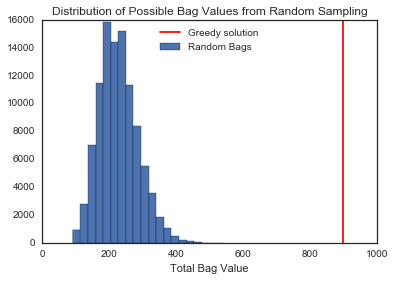

In [522]:
greedy_value = total_value(greedy_indices, v)

# We'll sample 100,000 of them to get an idea of how random bags are distributed
iterations = 100000

# Values of the samples bags
bags = np.zeros(iterations)

for i in range(iterations):
    bags[i] = total_value(random_bag(), v)
    
plt.hist(bags, bins = 20, label = "Random Bags")
plt.axvline(greedy_value, color='r', label = "Greedy solution")
plt.xlabel("Total Bag Value")
plt.title('Distribution of Possible Bag Values from Random Sampling')
plt.legend(loc='upper center')
plt.xlim([0,np.max([greedy_value,np.max(bags)])+103]);

#### For my simulated annealing, I will need a function that perturbs my current bag.  I tried a few different ways of doing this, and this one worked the best.  It simply picks an item to add to the bag, and then removes random items from the bag until the new item fits.  

In [524]:
# Function to swap items in and out of bag
def swap_items(indices, weights=w, values=v, max_weight=W):
    # Create a copy of the indices that were passed in.  This will be perturbed and returned.  
    indexes = np.copy(indices)

    # Create the array indices of items that are (in)/(not in) the bag
    idxs = np.array(range(len(indexes)))
    in_bag = idxs[indexes]
    out_bag = idxs[np.logical_not(indexes)]
    
    # Put a random item in
    out_swap = np.random.choice(out_bag)
    indexes[out_swap] = True
    
    # Take items out until that new item fits
    while total_weight(indexes, weights) > max_weight:
        in_swap = np.random.choice(in_bag)
        indexes[in_swap] = False
        
    return indexes

In [642]:
def simulated_annealing(indices, init_temp, min_temp, cool_by, reanneal, num_iter, values=v, weights=w, max_weight=W):
    """
    Inputs:
    -------
    indices: boolean array that indicates which possible items are in the bag
    init_temp: float that controls the initial temperature of the algorithm
    min_temp: float that acts as a floor for the decreasing temperature.  When this is hit, we heat back
        up to init_temp.  
    cool_by: float that controls the speed that the cooling occurs
    reanneal: integer that controls how many iterations pass between cooling steps
    num_iter: integer that controls the total number of iterations that the algorithm runs
    values: array of values of the items
    weights: array of weights of the items
    max_weight: float that is the maximum weight that can fit in the bag
    
    Returns:
    --------
    states: a history of the current energy state at each iteration
    best_bag_indices: the indices of the best bag that was found over all bags that were considered
    """
    
    # A running account of the best bag found.  This is updated as better bags are found.
    best_bag = total_value(indices, values)
    best_bag_indices = indices
    
    # We work with a copy of the original indices.
    indexes=np.copy(indices)
    
    # Initial value for old_E is the initial total value of the starting point.
    old_E = best_bag
    
    temperature = init_temp
    
    # Weight of proposed bag; we will propose bags until we find one under the max weight
    proposed_bag_weight = max_weight+1
    
    # A history of the current state of the algorithm
    states = np.zeros(num_iter)
    
    for i in range(num_iter):
        
        # Switch the bag up a little bit
        proposed_indices = swap_items(indexes)

        # Examine energy state of the new bag
        new_E = total_value(proposed_indices, values)
        delta_E = new_E - old_E
        
        # We always accept an improvement
        if new_E > old_E:
            indexes = proposed_indices
            states[i] = new_E
            old_E = new_E
            # Update our running best bag found
            if new_E > best_bag:
                best_bag = new_E
                best_bag_indices = indexes
        # We sometimes accept a decline because this can get us out of a local maximum
        elif np.random.rand() < np.exp(delta_E/temperature):
            indexes = proposed_indices
            states[i] = new_E
            old_E = new_E

        # And sometimes we just stay where we are until something better comes along
        else: 
            states[i] = old_E
            
        # Cool down slowly at the defined interval
        if num_iter % reanneal == 0:
            temperature = temperature * cool_by
            
            # Reheat when the temperature gets too cold
            if temperature < min_temp:
                temperature = init_temp
                
    return states, best_bag_indices

#### Through trial-and-error (and the rules of thumb presented in class), I found parameters that pretty consistently return a best bag found with a value of 916, which I believe is the global maximum.  I build these into a quick function below to display a few results.

In [656]:
## A function to display some demonstrations
def display(starting_bag):
    print "Value of starting bag:", total_value(starting_bag, v)
    st, ind = simulated_annealing(starting_bag, 10, 0.01, 0.99, 100, 50000, v, w, W)
    plt.plot(st)
    plt.title("History of Energy States")
    plt.xlabel("Iteration count")
    plt.ylabel("Bag Value")
    print "Best bag found:", total_value(ind,v)

Value of starting bag: 105
Best bag found: 916


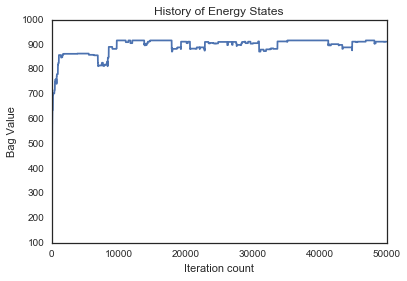

In [661]:
## Random starting bag
display(random_bag())

#### We can also use the indices found in the greedy implementation to give the algorithm a head start.  

Value of starting bag: 897
Best bag found: 916


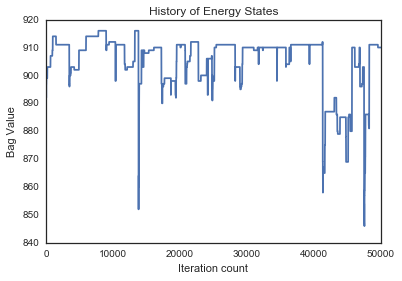

In [662]:
display(greedy_indices)

#### The algorithm even works if you start with an empty bag:

Value of starting bag: 0
Best bag found: 916


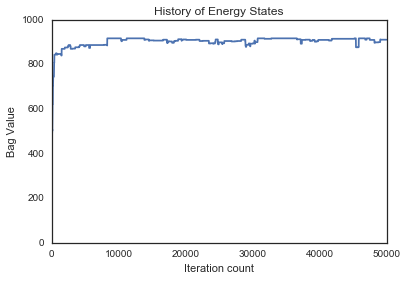

In [1140]:
display(np.zeros(100,dtype=bool))

#### In all cases, the behavior of the algorithm is apparent:
####    If the initial value is low, the algorithm quickly finds better arrangements and accepts these.  
####    Once it gets close to the maximum, it starts to have periods where it plateaus, sticking with one promising set as it is 'picky' about what changes it will accept.  
####    In ranges where the temperature is high, the value jumps down occasionally to accept lower value bags, and then rises from there again.  In this way, it gets out of local maxima and tends to find the global maximum eventually.  

### To compare the bags that the greedy algorithm and simulated annealing algorithm (SA) found, I present their combination below.  Here, I multiply the SA positives by five to distinguish them from the Greedy positives.  Thus there are four possible values:
#### 1) 6: This item is in both solutions
#### 2) 5: This item is only in the SA solution
#### 3) 1: This item is only in the Greedy solution
#### 4) 0: This item appears in neither solution.  

In [582]:
greedy_indices.astype(float) + 5*ind.astype(float)

array([ 6.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  1.,  0.,
        0.,  0.,  0.,  0.,  5.,  6.,  6.,  0.,  0.,  0.,  0.,  0.,  5.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  6.,
        6.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  6.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  6.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,
        6.,  6.,  6.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  6.,  0.,  0.,
        0.,  6.,  0.,  0.,  0.,  6.,  0.,  0.,  0.])

#### We can see that most of the items are common between the two solutions, and there are two items that are unique for each.  

(array([ 75.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  21.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

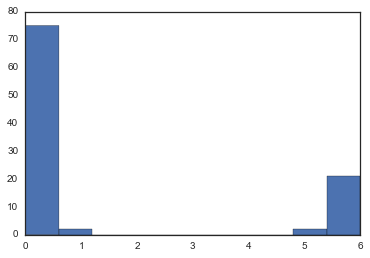

In [587]:
plt.hist(greedy_indices.astype(float) + 5*ind.astype(float))

# Problem 4: Confusing Classifications

You are a graduate student conducting research in image processing.  You want to test out your latest algorithm, which you decide to call "Ultra-Multilayer Hierarchical Super Convolutionary Neural Network."  However, in order to test out your algorithm, you need a sizable training data set. Luckly, your advisor has generously given you over 10 GB of over one million stock photos of cats and dogs.  Unfortunately, none of the images are labelled.  Fantastic!  You enjoy looking at photos of puppies and kittens in your spare time anyways so you decide to dedicate this entire weekend to labeling all of them. 

<table>
<tr>
 <td><img src="HW3/cat.jpeg" width=150>
 </td>
 <td><img src="HW3/dog.jpeg" width=150>
 </td>
</tr>
</table>

However, after spending two hours looking over hundreds of images, these puppies and kittens are no longer looking so cute.  In fact, you are starting to get disgusted at the idea of looking at another picture of these furry creatures.  

At this time, you decide to tap into the "power of the crowd" by farming out the labeling task to the workers of Amazon Mechanical Turk (MTurk). You decide to hire 3 MTurk workers.  However, you're not sure if these workers are reliable. So, how can you quantify the competency of the workers? In this problem you will develop a model to access the general difficulty of labeling the images of your two classes. 

Classifying items in general can be hard even for humans.  Some items just look alike, even if they actually are from two different classes. The difficulty in categorizing items of a specific class in relation to other classes is summarized by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

$$ \Theta = \left( 
\begin{array}{cc}
1.0 & 0.0 \\
0.5 & 0.5
\end{array}
\right ) $$

This confusion matrix indicates that items of class 1 are very easy to classify, and always correctly labeled, whereas items of class 2 are very hard to classify and labels are basically just random guesses between the two possibilities. 

The models we discussed so far in homework and lecture were pretty low in dimensions. This problem is going to show you that the number of dimensions can grow very fast for some models, making a good sampling strategy crucial. We will only be able to explore a very minimal version of the problem, because of our limited computational resources, but it should be immediately clear how this model would scale for a greater number of classes, workers, and/or items.

Develop a Bayesian model that takes as input a set of (possible erroneous) item labelings and infer the underlying confusion matrix and the true label each data point. To make the model manageable by your laptop, use only one underlying confusion matrix (in principle different people could have different difficulties) two classes for the labels (the confusion matrix is 2x2), and a maximum of 150 data points. 

The model you are after is displayed in the following dependency graph:
<img src="HW3/confusion_model.png" alt="confusion matrix model" width=300>


$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

You're given reports generated by the 3 workers, so $r_{i,1}$ is one label for item $r_i$ and $r_{i,2}$ is another label given from another worker. Note that if the confusion matrix is not the identity matrix then these labels can be different because the workers make mistakes. The arrows in the diagram indicate dependence. So the labelings you observe are dependent on the confusion matrix $\Theta$ and the underlying true label $z_i$ for each item. $N$ is the number of data points you have and as described above you should use $N \leq 150$.

You can see from the diagram that the model uses Multinomials with Dirichlet priors. 

1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels $z_i$. Discuss the meaning and influence of the hyperparameter $\alpha$ on the true labels of the data.

2. Discuss your selection of the hyperparameter $\Lambda$ and how that influences the confusion matrix $\Theta$.

3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix $\Theta$ and the distribution of the true labels $\rho$.  Note: $\Theta$ is shared by all three workers.

1.  The true classifications $z_i$ are drawn from a multinomial distribution that is controlled by the parameter $\rho$.  $\rho$ is a 1XN vector that tells the probability of each of the N classes.  In this case, there are 2 classes, so $\rho$ is 1X2.  The parameter $\alpha$ is a hyperparameter on the Dirichlet prior of the multinomial distribution, meaning that it controls the shape of the distribution that the population of $\rho$ values came from. The Dirichlet distribution is a conjugate prior of the multinomial, so the $\rho$ values will have a Dirichlet distribution.  The ratio of the values within the $\alpha$ vector control the relative probabilities of the two classes, and the magnitudes of these values control the certainty of these proportions.  High values of $\alpha$ will create a very peaked Dirichlet distribution, so when we sample we will be very likely to pick $\rho$ values that are close to the ratio that we have selected, and this corresponds to the situation where we are very certain of the prior probabilities.  

2.  The rows of the confusion matrix $\Theta$ are 1X2 vectors that distributed as Dirichlets controlled by the $\lambda$ vectors, which are also 1X2, within the $\Lambda$ matrix.  The hyperparameter $\Lambda$ reflects our prior knowledge about how accurate the workers are.  For example, if we believe that the workers are always 100% accurate for both classes, we could pick $\lambda$ vectors with higher values along the diagonal to reflect that they are mostly accurate.  Conversely, if we believe that the workers are often inaccurate, the values along the diagonal would be relatively lower compared to the non-diagonal elements.  As above, the magnitude of these values controls our certainty.  So for example, if we are very confident in our prior belief that the workers are 90% accurate for both classes, we could pick

$$\Lambda = 
\left( 
\begin{array}{cc}
900 & 100 \\
100 & 900
\end{array} 
\right)$$
but if we are less confident about the same belief of 90% accuracy, we could pick $$\Lambda =
\left(
\begin{array}{cc}
9 & 1 \\
1 & 9
\end{array}
\right)$$



In [1413]:
# Here is your data

reports = np.load("HW3/reports.npy")

In [1689]:
# Define hyperparameters for the priors:

# These values reflect a prior belief that the workers are mostly accurate, but with a low confidence in this belief. 
Lambda = np.array([[3,1],
                   [1,3]])

# These values reflect a prior belief that half of the images are cats and the other half are dogs, 
#    with low confidence.  
alpha = [1,1]

# These values give a runtime of about five minutes for the sampling, which was suitable for tweaking the 
#    hyperparameters.  
num_iterations = 2000
num_burn = 200
thin=10

In [1690]:
# We create a Dirichlet distribution with the prior alpha
rho1 = pm.Dirichlet('rho1', alpha, trace=False)

# We have to complete it to give the probabilities of each class
rho2 = pm.CompletedDirichlet("rho2",rho1)


# We create two Dirichlets, one for each row of Theta.  Each row is created using the corresponding
#    prior on that row in Lambda
Theta1 = [pm.Dirichlet('theta_row0_1', Lambda[0], trace=False), \
          pm.Dirichlet('theta_row1_1', Lambda[1], trace=False)]

# As above, we need to complete each one to give both probabilities.
Theta2 = [pm.CompletedDirichlet('theta_row0_2', Theta1[0]), pm.CompletedDirichlet('theta_row1_2', Theta1[1])]

# We put these in a container so that they can be indexed
Theta = pm.Container(Theta2)


# For each of the 150 images, we will draw a single sample from the Multinomial distribution using the 
#    prior rho.  These need to be wrapped in a container to index them
z = pm.Container([pm.Multinomial('z_%i' % i, n=1, p=rho2, trace=False) for i in range(150)])


# Likelihood function
@pm.observed
def likelihood(value=reports, theta = Theta, z=z):
    likelihood=0
    # Go over all items
    for n in range(150):
        # Go over each of the three workers' classification for each item
        for j in range(3):
            # Find the true class
            idx_of_true = np.argmax(z[n])
            # Log-likelihood is sum of log-likelihoods for each worker's classification of each image
            likelihood += pm.multinomial_like(value[n,j], n=1, p=theta[idx_of_true])

    return likelihood


M = pm.MCMC([rho1, rho2, Theta1, Theta2, Theta, z, likelihood])
M.sample(num_iterations, num_burn, thin)
# M.summary()
stats = M.stats()

 [-----------------100%-----------------] 2001 of 2000 complete in 269.3 sec

In [1692]:
M.summary()


theta_row1_2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.323            0.042            0.004            [ 0.232  0.408]
	0.677            0.042            0.004            [ 0.592  0.768]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.221            0.298           0.324          0.353         0.406
	0.594            0.649           0.677          0.702         0.779
	

theta_row0_2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.801            0.084            0.007            [ 0.67   0.973]
	0.199            0.084            0.007            [ 0.027  0.33 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|=

Plotting theta_row0_2_0_0
Plotting theta_row0_2_0_1


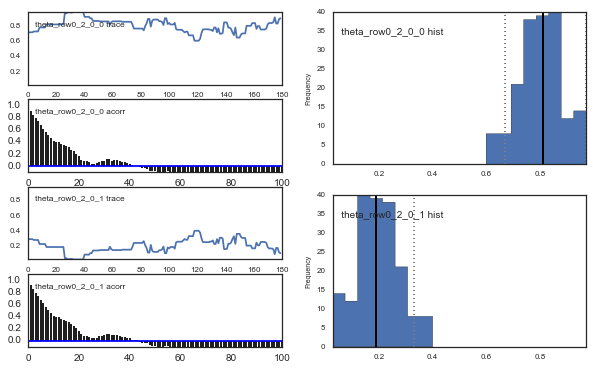

In [1709]:
pm.Matplot.plot(Theta[0])

Plotting theta_row1_2_0_0
Plotting theta_row1_2_0_1


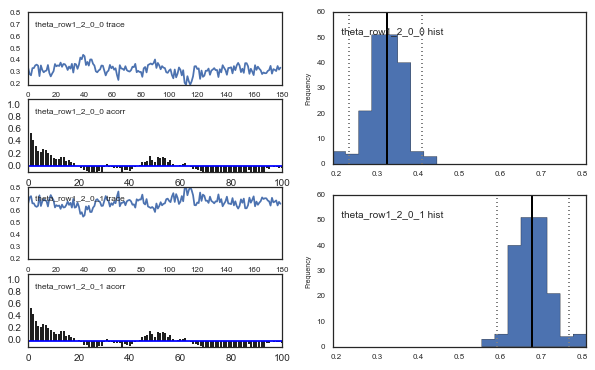

In [1710]:
pm.Matplot.plot(Theta[1])

We see strong evidence for convergence of the sampling for the rows of $\Theta$ in the low autocorrelation values, and the fact that the trace plots are centered at the mean values.  The case for convergence of $\rho$ is less strong, as evidenced by a more volatile and autocorrelated traceplot, and higher variance for the prediction.  

Plotting rho2_0_0
Plotting rho2_0_1


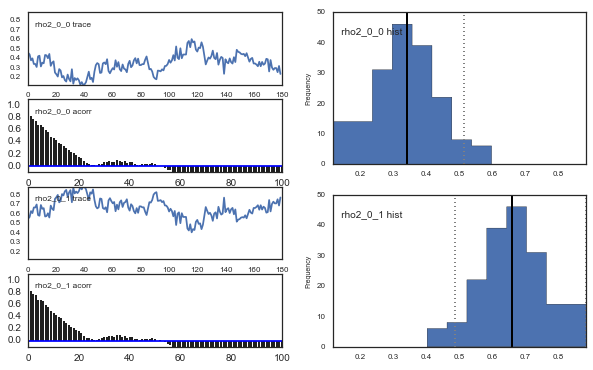

In [1708]:
pm.Matplot.plot(rho2)

In [1705]:
stats['theta_row0_2']

{'95% HPD interval': array([[ 0.66960612,  0.02674299],
        [ 0.97325701,  0.33039388]]),
 'mc error': array([ 0.00710957,  0.00710957]),
 'mean': array([ 0.80105847,  0.19894153]),
 'n': 180,
 'quantiles': {2.5: array([ 0.6250951 ,  0.02674299]),
  25: array([ 0.74560559,  0.14830255]),
  50: array([ 0.81141455,  0.18858545]),
  75: array([ 0.85169745,  0.25439441]),
  97.5: array([ 0.97325701,  0.3749049 ])},
 'standard deviation': array([ 0.0842546,  0.0842546])}

In [1706]:
stats['theta_row1_2']

{'95% HPD interval': array([[ 0.23187452,  0.59203194],
        [ 0.40796806,  0.76812548]]),
 'mc error': array([ 0.00384406,  0.00384406]),
 'mean': array([ 0.32280887,  0.67719113]),
 'n': 180,
 'quantiles': {2.5: array([ 0.22074502,  0.59411642]),
  25: array([ 0.29843312,  0.64864198]),
  50: array([ 0.32393346,  0.67670852]),
  75: array([ 0.35264257,  0.70226602]),
  97.5: array([ 0.40588358,  0.77925498])},
 'standard deviation': array([ 0.0418046,  0.0418046])}

In [1707]:
stats['rho2']

{'95% HPD interval': array([[ 0.11619345,  0.48746724],
        [ 0.51253276,  0.88380655]]),
 'mc error': array([ 0.00849035,  0.00849035]),
 'mean': array([ 0.33723467,  0.66276533]),
 'n': 180,
 'quantiles': {2.5: array([ 0.14336444,  0.4364438 ]),
  25: array([ 0.26837566,  0.60053309]),
  50: array([ 0.34086468,  0.65913532]),
  75: array([ 0.39967943,  0.73207729]),
  97.5: array([ 0.5635562 ,  0.85663556])},
 'standard deviation': array([ 0.10121858,  0.10121858])}

In summary: 

The $\rho$ value determined by the sampling is $$\rho = \left(\begin{array}{cc}0.34& 0.66\end{array}\right)$$

 with standard deviations 
 $$\sigma_{\rho} = \left(\begin{array}{cc}0.1& 0.1\end{array}\right)$$

The $\Theta$ determined by the sampling is 
$$ \Theta = 
\left(
\begin{array}{cc}
0.80 & 0.20 \\
0.32 & 0.68
\end{array}
\right)$$

with standard deviations
$$\sigma_{\Theta} = \left(
\begin{array}{cc}
0.08 & 0.08 \\
0.04 & 0.04
\end{array}
\right)$$



Acknowledgements: I got a lot of help from Richard and Rafael.  I also worked with Victor Lei, Sam Daulton, Reinier Maat, Taylor Killian, Andrew Petzchek, Abhishek Malali, Avery Faller.  